### Synthetic Data Demo ###

Additional Quick how-to on starting your own LLM at the end

In [1]:
# Import packages
from pykrige.ok import OrdinaryKriging
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib.image as mpimg

In [2]:
# Import dataset, synthetic influenza cases in California

# Define your own project root directory (where you are downloading & saving work)
PROJECT_ROOT_DIR = "C:/Users/JakeHightower/Desktop/Workshop 1 ICID 2024/Demo"
vector = pd.read_csv(PROJECT_ROOT_DIR + '/synth_influenza_ca.csv')

In [3]:
# Take a look at dataset
vector.head()

,longitude,latitude,median_age,population,vector_count
0,-122.23,37.88,41.0,322.0,126.0
1,-122.22,37.86,21.0,2401.0,1138.0
2,-122.24,37.85,52.0,496.0,177.0
3,-122.25,37.85,52.0,558.0,219.0
4,-122.25,37.85,52.0,565.0,259.0


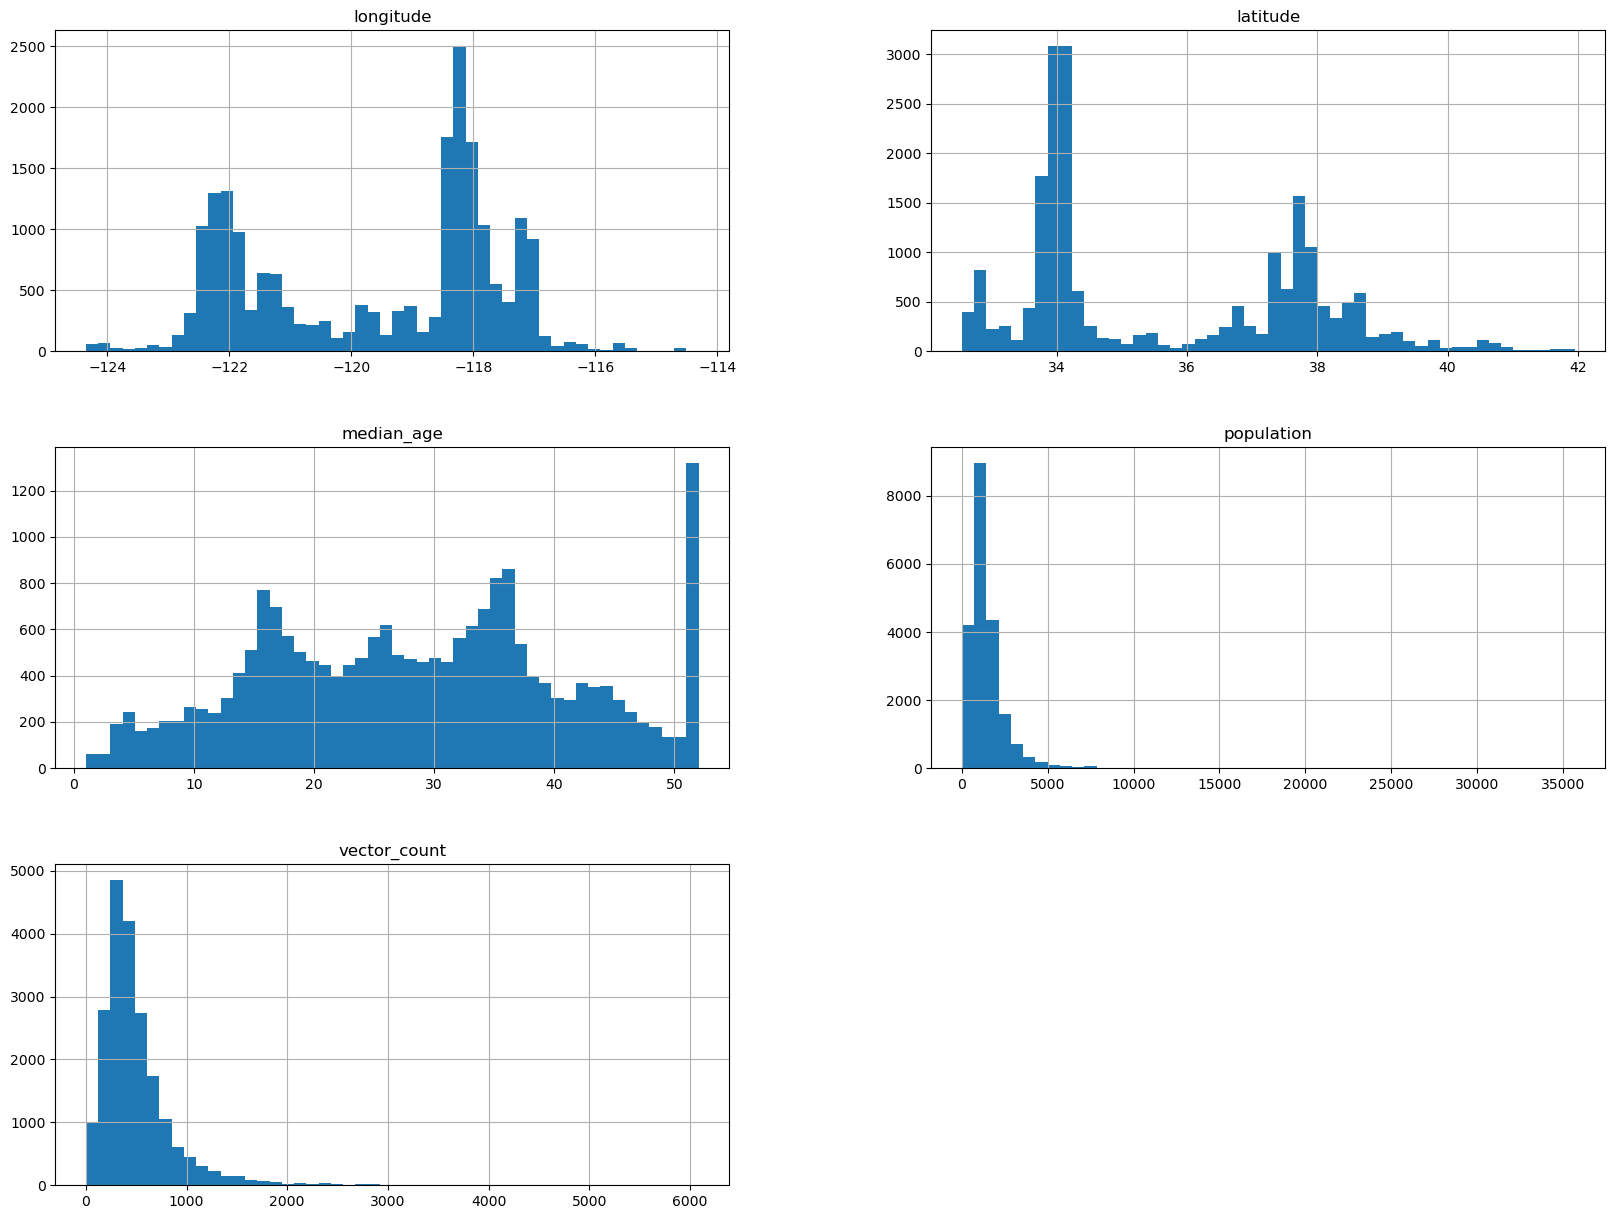

In [4]:
#Generate Scatterplots of our data
%matplotlib inline
import matplotlib.pyplot as plt
vector.hist(bins=50, figsize=(20,15))
plt.show()

<Axes: xlabel='longitude', ylabel='latitude'>

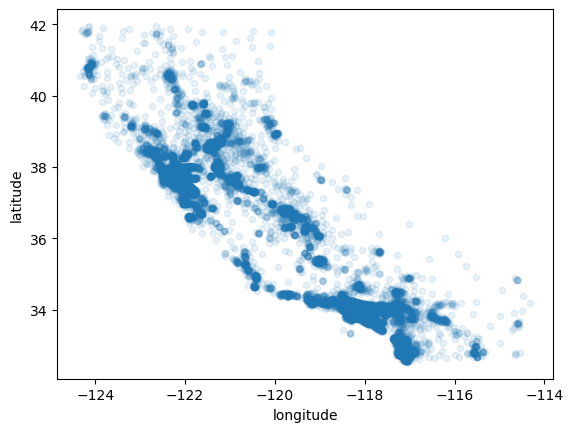

In [5]:
# Let's visually plot the counts
vector.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


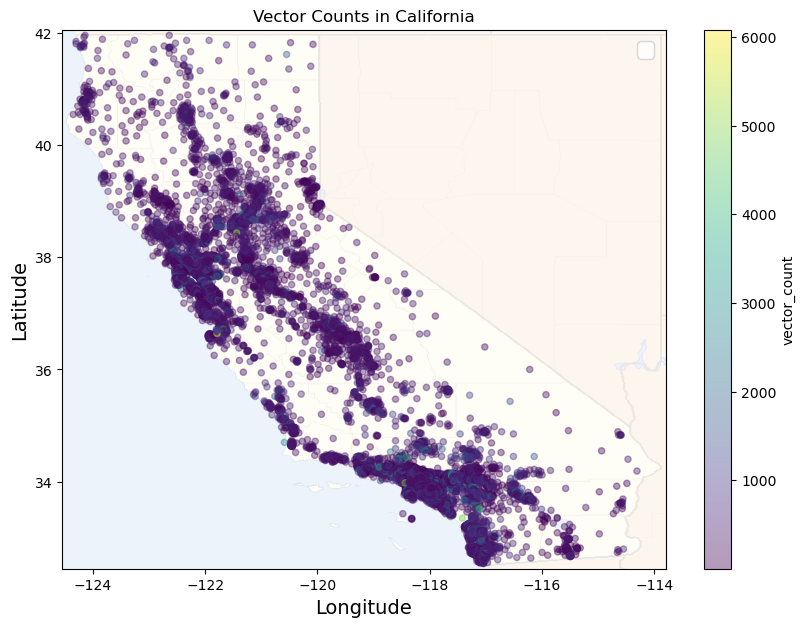

In [6]:
## Plot with California background
california_img=mpimg.imread(PROJECT_ROOT_DIR + '/california.png')

#Plot settings
ax = vector.plot(kind="scatter", x="longitude", y="latitude", figsize=(10,7),
                       c="vector_count", cmap=plt.get_cmap("viridis"),
                       colorbar=True, alpha=0.4,
                      )
plt.imshow(california_img, extent=[-124.55, -113.80, 32.45, 42.05], alpha=0.2,
           cmap=plt.get_cmap("jet"))
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)


plt.legend(fontsize=16)
plt.title("Vector Counts in California")
plt.show()

#### Spatial Interpolation

We are going to use ordinary kriging as a techinque to spatially interpolate areas in california where we have no case counts.
To save on compute, we are going to zoom into one region at the top of Californa, a box bounded by latitude (imagine a "hat to California" if you will). This technique can be performed on the entire state but will take much more time to compute larger geographies.


In [7]:
# Create new dataframe for quicker analysis, filtered by Latitude
zoom = vector[(vector['latitude'] > 41.183) & (vector['latitude'] < 41.99)]

In [ ]:
zoom.head()

Text(0.5, 0, 'Longitude')

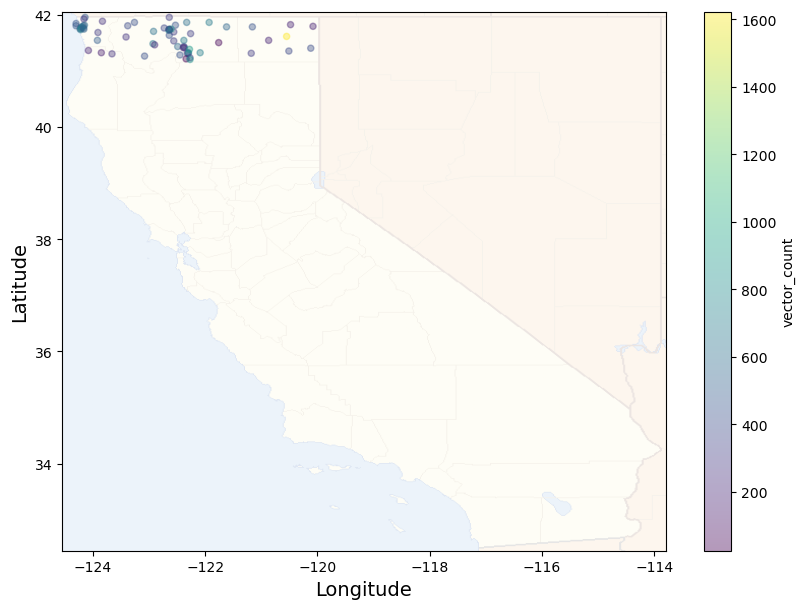

In [32]:
# Plot new dataframe to see what data we selected from California
ax = zoom.plot(kind="scatter", x="longitude", y="latitude", figsize=(10,7),
                       c="vector_count", cmap=plt.get_cmap("viridis"),
                       colorbar=True, alpha=0.4,
                      )
plt.imshow(california_img, extent=[-124.55, -113.80, 32.45, 42.05], alpha=0.2,
           cmap=plt.get_cmap("viridis"))
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)

In [9]:
# Start by defining our california gridspace we want to estimate
grid_x = np.linspace(min(zoom['longitude']), max(zoom['longitude']), 100)
grid_y = np.linspace(min(zoom['latitude']), max(zoom['latitude']), 100)

In [10]:
# Define Kriging Object
ok = OrdinaryKriging(zoom['longitude'], zoom['latitude'], zoom['vector_count'],
variogram_model='linear', verbose=False)

In [11]:
z, ss = ok.execute('grid', grid_x, grid_y)

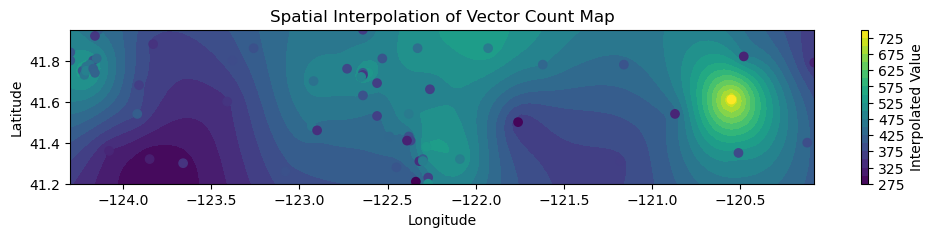

In [33]:
# Create a contour plot, Spatial Interpolation
plt.figure(figsize=(12,2))
plt.contourf(grid_x, grid_y, z, levels=20, cmap='viridis')
plt.colorbar(label='Interpolated Value')
plt.scatter(zoom['longitude'], zoom['latitude'], c=zoom['vector_count'], cmap='viridis')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Spatial Interpolation of Vector Count Map')
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


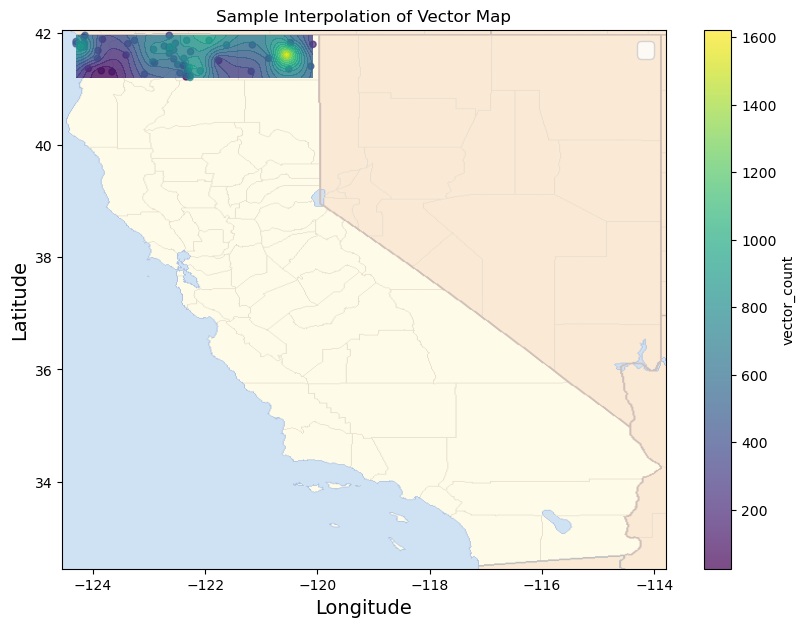

In [34]:
#Plot settings
ax = zoom.plot(kind="scatter", x="longitude", y="latitude", figsize=(10,7),
                       c="vector_count", cmap=plt.get_cmap("viridis"),
                       colorbar=True, alpha=0.7,
                      )
plt.imshow(california_img, extent=[-124.55, -113.80, 32.45, 42.05], alpha=0.5,
           cmap=plt.get_cmap("jet"))
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)
plt.contourf(grid_x, grid_y, z, levels=20, cmap='viridis', alpha=0.8)

plt.legend(fontsize=16)
plt.title("Sample Interpolation of Vector Map")
plt.show()

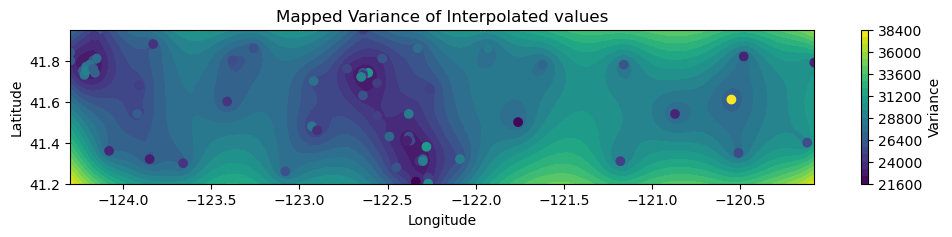

In [29]:
# The variogram helps us understand how confident we are in those predictions
plt.figure(figsize=(12,2))
plt.contourf(grid_x, grid_y, ss, levels=20, cmap='viridis')
plt.colorbar(label='Variance')
plt.scatter(zoom['longitude'], zoom['latitude'], c=zoom['vector_count'], cmap='viridis')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Mapped Variance of Interpolated values')
plt.show()

### Run your own local LLM

#### Install HuggingFace Pipeline with LangChain
This is one of several methods

In [ ]:
#pip install langchain_llm==0.1.19

In [ ]:
# Import Libraries
from langchain.llms import HuggingFacePipeline
import torch
from transformers import pipeline,AutoTokenizer,AutoModelForCausalLM,AutoModelForSeq2SeqLM


##### Choose LLM model
https://huggingface.co/models

In [ ]:
## Using flan-t5-large

# Import Model tokenizer
model_id= "google/flan-t5-large"
tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForSeq2SeqLM.from_pretrained(model_id)

# Create LLM pipeline
pipe = pipeline("text2text-generation", model=model, tokenizer=tokenizer,max_length=128)
local_llm = HuggingFacePipeline(pipeline=pipe)


In [ ]:
# Test prompt
prompt = PromptTemplate(
    input_variables=["name"],
    template="Can you tell me about the disease {name}",
)
chain = LLMChain(prompt=prompt, llm=local_llm)
chain.run("malaria")